<a href="https://colab.research.google.com/github/28nahidhasan/Thesis-Summer-24-25-/blob/main/Nahid_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nahidhasan28_thesiss_path = kagglehub.dataset_download('nahidhasan28/thesiss')
nahidhasan28_v3_keras_default_1_path = kagglehub.model_download('nahidhasan28/v3/Keras/default/1')

print('Data source import complete.')


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("Setup complete, TensorFlow version:", tf.__version__)


Setup complete, TensorFlow version: 2.18.0


**Load and Verify Images**

In [ ]:
# Update dataset path as per your environment
dataset_path = '/kaggle/input/thesiss/Thesis Pictures'
assert os.path.exists(dataset_path), "Dataset path missing!"

categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Categories found:", categories)

IMG_SIZE = (299, 299)
images, labels, image_metadata = [], [], []

for category in categories:
    cat_path = os.path.join(dataset_path, category)
    for fname in os.listdir(cat_path):
        fpath = os.path.join(cat_path, fname)
        if os.path.isdir(fpath):
            continue
        try:
            with Image.open(fpath) as img:
                img.verify()
            img_cv = cv2.imread(fpath)
            if img_cv is not None:
                images.append(img_cv)
                labels.append(category)
                image_metadata.append({'file_path': fpath, 'label': category})
            else:
                print(f"Warning: could not load image by cv2: {fpath}")
        except Exception as e:
            print(f"Skipping invalid image {fpath}: {e}")

print(f"Total images loaded: {len(images)}")
gc.collect()


Categories found: ['Powdery mildew', 'Phytophthora bligh', 'Bacterial leaf spot', 'Cabbage looper', 'Bacterial wilt', 'Alternaria cucumerina', 'mosaic', 'Southern blight', 'Fusarium', 'Alternaria leaf blight', 'Gummy stem blight', 'Armyworms', 'Squash vine borer', 'Cucumber beetles', 'Squash bug', 'Aphids', 'Flea beetles', 'Thrips (Western flower thrips)']
Total images loaded: 1690


33

**Resize ,Color convert ,Clean and Normalize**

In [ ]:
# Resize images to target size and convert BGR to RGB
images_resized = []
for img in images:
    resized = cv2.resize(img, IMG_SIZE)
    rgb_img = cv2.cvtColor(resized.astype(np.uint8), cv2.COLOR_BGR2RGB)
    images_resized.append(rgb_img)
images = np.array(images_resized)
#color convert
print("Resized images to", IMG_SIZE, "and converted to RGB")
del images_resized
gc.collect()

#Clean and Normalize
valid_images, valid_labels, valid_meta = [], [], []

for img, lbl, meta in zip(images, labels, image_metadata):
    if img.shape == (299, 299, 3) and not np.isnan(img).any():
        valid_images.append(img)
        valid_labels.append(lbl)
        valid_meta.append(meta)
    else:
        print(f"Removing invalid image: {meta['file_path']}")

images = np.array(valid_images).astype(np.float32)
labels = np.array(valid_labels)
image_metadata = valid_meta

images /= 255.0
print(f"After cleaning, {len(images)} images remain")
gc.collect()


Resized images to (299, 299) and converted to RGB
After cleaning, 1690 images remain


0

**Crop and pad**

In [ ]:
CROP_SIZE = (200, 200)
PAD_SIZE = (299, 299)

cropped_imgs = []
for img in images:
    h, w = img.shape[:2]
    start_x = (w - CROP_SIZE[0]) // 2
    start_y = (h - CROP_SIZE[1]) // 2
    cropped = img[start_y:start_y + CROP_SIZE[1], start_x:start_x + CROP_SIZE[0]]
    cropped_imgs.append(cropped)
images = np.array(cropped_imgs)
del cropped_imgs

padded_imgs = []
for img in images:
    h, w = img.shape[:2]
    top = (PAD_SIZE[1] - h) // 2
    bottom = PAD_SIZE[1] - h - top
    left = (PAD_SIZE[0] - w) // 2
    right = PAD_SIZE[0] - w - left
    padded = np.pad(img, ((top, bottom), (left, right), (0, 0)), mode='constant', constant_values=0)
    padded_imgs.append(padded)
images = np.array(padded_imgs)
del padded_imgs

print(f"Cropped images to {CROP_SIZE} and padded back to {PAD_SIZE}.")
gc.collect()


Cropped images to (200, 200) and padded back to (299, 299).


0

**Data Augmentation**

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

num_aug_per_img = 2 # Number of augmented images to generate per original image

augmented_images = []
augmented_labels = []

for i in range(len(images)):
    img = images[i].reshape((1, *images[i].shape))
    label = labels[i]
    it = datagen.flow(img, batch_size=1)
    for _ in range(num_aug_per_img):
        new_img = next(it)[0].astype(np.float32)
        augmented_images.append(new_img)
        augmented_labels.append(label)


augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Generated {len(augmented_images)} augmented images.")
gc.collect()
np.save('/kaggle/working/augmented_images.npy', augmented_images)
np.save('/kaggle/working/augmented_labels.npy', augmented_labels)
print("Augmented images and labels saved to /kaggle/working/")



Generated 3380 augmented images.
Augmented images and labels saved to /kaggle/working/


**Shuffle and Label Encoding**

In [ ]:
images, labels, image_metadata = shuffle(images, labels, image_metadata, random_state=42)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Label classes:", label_encoder.classes_)

# Save encoded labels and encoder for reuse
np.save('/kaggle/working/labels_encoded.npy', labels_encoded)
with open('/kaggle/working/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Saved labels_encoded.npy and label_encoder.pkl")

gc.collect()


Label classes: ['Alternaria cucumerina' 'Alternaria leaf blight' 'Aphids' 'Armyworms'
 'Bacterial leaf spot' 'Bacterial wilt' 'Cabbage looper'
 'Cucumber beetles' 'Flea beetles' 'Fusarium' 'Gummy stem blight'
 'Phytophthora bligh' 'Powdery mildew' 'Southern blight' 'Squash bug'
 'Squash vine borer' 'Thrips (Western flower thrips)' 'mosaic']
Saved labels_encoded.npy and label_encoder.pkl


0

**Split and Save**

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

np.save('/kaggle/working/train_images.npy', train_images)
np.save('/kaggle/working/train_labels.npy', train_labels)
np.save('/kaggle/working/test_images.npy', test_images)
np.save('/kaggle/working/test_labels.npy', test_labels)

print(f"Training images: {len(train_images)}, Testing images: {len(test_images)}")

# Print class distribution
train_dist = pd.Series(label_encoder.inverse_transform(train_labels)).value_counts()
test_dist = pd.Series(label_encoder.inverse_transform(test_labels)).value_counts()
print("Training class distribution:\n", train_dist)
print("Testing class distribution:\n", test_dist)

gc.collect()


Training images: 1352, Testing images: 338
Training class distribution:
 Cucumber beetles                  110
Alternaria leaf blight             94
Thrips (Western flower thrips)     91
Bacterial wilt                     90
Flea beetles                       90
Fusarium                           83
Squash vine borer                  83
Squash bug                         83
Phytophthora bligh                 80
Armyworms                          80
Bacterial leaf spot                80
Gummy stem blight                  80
Alternaria cucumerina              79
mosaic                             57
Cabbage looper                     55
Aphids                             54
Southern blight                    32
Powdery mildew                     31
Name: count, dtype: int64
Testing class distribution:
 Cucumber beetles                  28
Bacterial wilt                    23
Thrips (Western flower thrips)    23
Alternaria leaf blight            23
Flea beetles                      22
Squ

0

**Compute and Save Class Weights**

In [ ]:
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

with open('/kaggle/working/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

print("Saved class_weights.pkl")


Class weights: {0: 0.9507735583684951, 1: 0.7990543735224587, 2: 1.3909465020576133, 3: 0.9388888888888889, 4: 0.9388888888888889, 5: 0.8345679012345679, 6: 1.3656565656565656, 7: 0.6828282828282828, 8: 0.8345679012345679, 9: 0.9049531459170014, 10: 0.9388888888888889, 11: 0.9388888888888889, 12: 2.4229390681003586, 13: 2.3472222222222223, 14: 0.9049531459170014, 15: 0.9049531459170014, 16: 0.8253968253968254, 17: 1.3177387914230019}
Saved class_weights.pkl


**Data Generator**

In [ ]:
def data_generator(image_path, label_path, batch_size, num_classes, class_weights, label_encoder):
    images = np.load(image_path, mmap_mode='r')
    labels = np.load(label_path, mmap_mode='r')

    # Filter invalid labels if string
    if labels.dtype.type is np.str_:
        valid_mask = np.isin(labels, label_encoder.classes_)
        valid_indices = np.where(valid_mask)[0]
        if len(valid_indices) < len(labels):
            print(f"Filtered {len(labels) - len(valid_indices)} invalid labels.")
        labels = label_encoder.transform(labels[valid_indices])
        images = images[valid_indices]

    num_samples = len(labels)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_idx = indices[start_idx:start_idx + batch_size]
            batch_images = images[batch_idx]
            batch_labels = labels[batch_idx]
            batch_labels_one_hot = to_categorical(batch_labels, num_classes)
            batch_sample_weights = np.array([class_weights[int(lbl)] for lbl in batch_labels])

            yield batch_images, batch_labels_one_hot, batch_sample_weights

    del images, labels
    gc.collect()


**Model Building**

In [ ]:
# Load label encoder
import pickle
with open('/kaggle/working/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)
print(f'Number of classes: {num_classes}')

# Path to a weights file
weights_path = '/kaggle/input/v3/keras/default/1/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

if os.path.exists(weights_path):
    weights_arg = weights_path
else:
    weights_arg = 'imagenet'

base_model = InceptionV3(
    weights=weights_arg,
    include_top=False,
    input_shape=(299, 299, 3)
)

# Freeze first 200 layers as before
for layer in base_model.layers[:200]:
    layer.trainable = False
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Number of classes: 18


2025-07-25 19:17:41.163305: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,861,106 (87.21 MB)

 Trainable params: 15,862,610 (60.51 MB)

 Non-trainable params: 6,998,496 (26.70 MB)

None


**Train**

In [ ]:
batch_size = 8
num_classes = len(label_encoder.classes_)

train_gen = data_generator('/kaggle/working/train_images.npy', '/kaggle/working/train_labels.npy',
                           batch_size, num_classes, class_weights, label_encoder)
val_gen = data_generator('/kaggle/working/test_images.npy', '/kaggle/working/test_labels.npy',
                         batch_size, num_classes, class_weights, label_encoder)

steps_per_epoch = len(np.load('/kaggle/working/train_labels.npy', mmap_mode='r')) // batch_size
validation_steps = len(np.load('/kaggle/working/test_labels.npy', mmap_mode='r')) // batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.0983 - loss: 2.9047 - val_accuracy: 0.3929 - val_loss: 2.4349
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.3799 - loss: 2.3342 - val_accuracy: 0.4940 - val_loss: 2.0414
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.5398 - loss: 1.8770 - val_accuracy: 0.5333 - val_loss: 1.7296
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.6225 - loss: 1.5250 - val_accuracy: 0.5667 - val_loss: 1.4836
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.6811 - loss: 1.2624 - val_accuracy: 0.5909 - val_loss: 1.3441
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.7454 - loss: 1.0080 - val_accuracy: 0.5667 - val_loss: 1.3567
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7849 - loss: 0.8488 - val_accuracy: 0.6455 - val_loss: 1.1685
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8480 - loss: 0.6868 - val_accu

**Evaluation**

In [ ]:
test_images = np.load('/kaggle/working/test_images.npy', mmap_mode='r')
test_labels = np.load('/kaggle/working/test_labels.npy')
test_labels_one_hot = to_categorical(test_labels, num_classes)

loss, accuracy = model.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

model.save('/kaggle/working/model.h5')
print("Saved trained model to /kaggle/working/model.h5")


11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6404 - loss: 1.1832
Test Accuracy: 64.20%
Test Loss: 1.1436
Saved trained model to /kaggle/working/model.h5


**Plot**

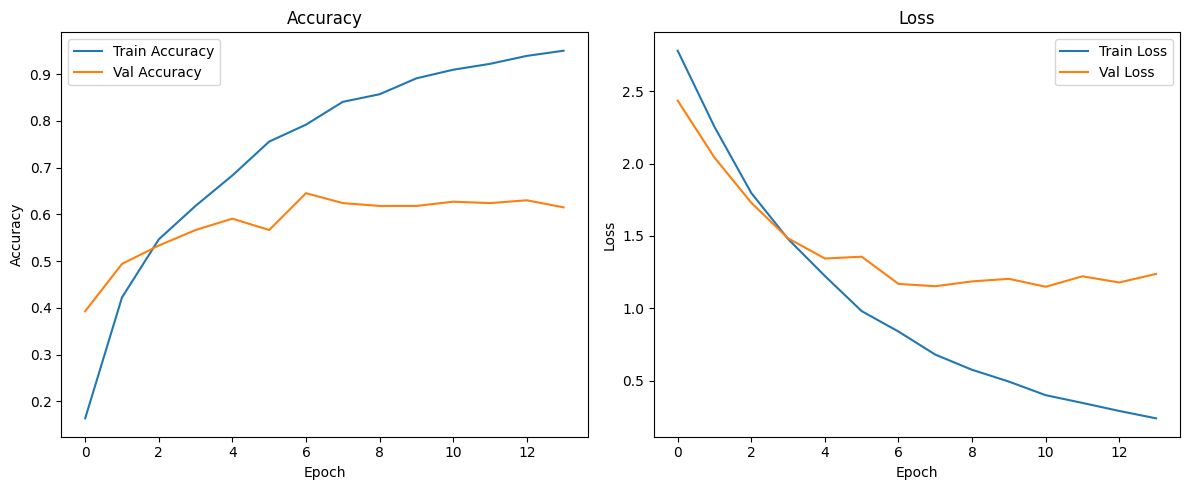

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
